<a href="https://colab.research.google.com/github/Firojpaudel/Deepseek_implementation_scratch/blob/main/MHA_MQA_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@ Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MHA(nn.Module):
    """Lightweight Multi-Head Attention model."""
    def __init__(self, d_model, num_heads, num_layers=1, head_dim=None):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = head_dim or d_model // num_heads
        self.num_layers = num_layers
        self.q_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.k_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.v_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.out_projs = nn.ModuleList([nn.Linear(num_heads * self.head_dim, d_model, bias=False) for _ in range(num_layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_layers)])

    def forward(self, x, cache=None):
        b, tgt_len, _ = x.shape
        if cache is None:
            cache = [None] * self.num_layers
        new_cache = []
        for i in range(self.num_layers):
            residual = x
            x_norm = self.norms[i](x)
            q = self.q_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)  # b n tgt_len h
            if cache[i] is None:
                k = self.k_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                v = self.v_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                ck, cv = k, v
            else:
                ck, cv = cache[i]
                k_new = self.k_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                v_new = self.v_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)
                ck = torch.cat([ck, k_new], dim=2)
                cv = torch.cat([cv, v_new], dim=2)
            attn_output = F.scaled_dot_product_attention(q, ck, cv)
            attn_output = attn_output.transpose(1, 2).contiguous().view(b, tgt_len, -1)
            x = residual + self.out_projs[i](attn_output)
            new_cache.append((ck, cv))
        return x, new_cache

class MQA(nn.Module):
    """Lightweight Multi-Query Attention model (shared KV heads)."""
    def __init__(self, d_model, num_heads, num_layers=1, head_dim=None):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = head_dim or d_model // num_heads
        self.num_layers = num_layers
        self.num_kv_heads = 1
        self.q_projs = nn.ModuleList([nn.Linear(d_model, num_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.k_projs = nn.ModuleList([nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.v_projs = nn.ModuleList([nn.Linear(d_model, self.num_kv_heads * self.head_dim, bias=False) for _ in range(num_layers)])
        self.out_projs = nn.ModuleList([nn.Linear(num_heads * self.head_dim, d_model, bias=False) for _ in range(num_layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(num_layers)])

    def forward(self, x, cache=None):
        b, tgt_len, _ = x.shape
        if cache is None:
            cache = [None] * self.num_layers
        new_cache = []
        for i in range(self.num_layers):
            residual = x
            x_norm = self.norms[i](x)
            q = self.q_projs[i](x_norm).view(b, tgt_len, self.num_heads, self.head_dim).transpose(1, 2)  # b n tgt_len h
            if cache[i] is None:
                k = self.k_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                v = self.v_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                ck, cv = k, v
            else:
                ck, cv = cache[i]
                k_new = self.k_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                v_new = self.v_projs[i](x_norm).view(b, tgt_len, self.num_kv_heads, self.head_dim).transpose(1, 2)
                ck = torch.cat([ck, k_new], dim=2)
                cv = torch.cat([cv, v_new], dim=2)
            # Repeat KV to match num_heads
            k_repeated = ck.repeat(1, self.num_heads, 1, 1)
            v_repeated = cv.repeat(1, self.num_heads, 1, 1)
            attn_output = F.scaled_dot_product_attention(q, k_repeated, v_repeated)
            attn_output = attn_output.transpose(1, 2).contiguous().view(b, tgt_len, -1)
            x = residual + self.out_projs[i](attn_output)
            new_cache.append((ck, cv))
        return x, new_cache

def get_cache_size(cache):
    """Compute total bytes in KV cache."""
    total_bytes = 0
    for layer_cache in cache:
        k, v = layer_cache
        total_bytes += (k.numel() + v.numel()) * k.element_size()
    return total_bytes

In [3]:
# Config (lightest models)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
d_model = 128
num_heads = 8
head_dim = d_model // num_heads
num_layers = 2
b = 1
max_s = 1024  # Max sequence length for generation sim

mha_model = MHA(d_model, num_heads, num_layers, head_dim).to(device)
mqa_model = MQA(d_model, num_heads, num_layers, head_dim).to(device)

In [4]:
# Model param memory
mha_params_bytes = sum(p.numel() * p.element_size() for p in mha_model.parameters())
mqa_params_bytes = sum(p.numel() * p.element_size() for p in mqa_model.parameters())
print(f"MHA model params memory: {mha_params_bytes} bytes (~{mha_params_bytes / 1024 / 1024:.2f} MB)")
print(f"MQA model params memory: {mqa_params_bytes} bytes (~{mqa_params_bytes / 1024 / 1024:.2f} MB)")

# Simulate generation and measure KV cache
print("\nseq_len | MHA KV bytes | MQA KV bytes")
print("--------|--------------|--------------")
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()  # Uncomment for peak GPU tracking

mha_cache = None
mqa_cache = None
mha_sizes, mqa_sizes = [], []
for pos in range(1, max_s + 1):
    x = torch.randn(b, 1, d_model, device=device)
    _, mha_cache = mha_model(x, mha_cache)
    _, mqa_cache = mqa_model(x, mqa_cache)
    mha_size = get_cache_size(mha_cache)
    mqa_size = get_cache_size(mqa_cache)
    mha_sizes.append(mha_size)
    mqa_sizes.append(mqa_size)
    if pos % 100 == 0 or pos <= 10:  # Print every 100 + first 10
        print(f"{pos:7d} | {mha_size:12d} | {mqa_size:11d}")

MHA model params memory: 526336 bytes (~0.50 MB)
MQA model params memory: 296960 bytes (~0.28 MB)

seq_len | MHA KV bytes | MQA KV bytes
--------|--------------|--------------
      1 |         2048 |         256
      2 |         4096 |         512
      3 |         6144 |         768
      4 |         8192 |        1024
      5 |        10240 |        1280
      6 |        12288 |        1536
      7 |        14336 |        1792
      8 |        16384 |        2048
      9 |        18432 |        2304
     10 |        20480 |        2560
    100 |       204800 |       25600
    200 |       409600 |       51200
    300 |       614400 |       76800
    400 |       819200 |      102400
    500 |      1024000 |      128000
    600 |      1228800 |      153600
    700 |      1433600 |      179200
    800 |      1638400 |      204800
    900 |      1843200 |      230400
   1000 |      2048000 |      256000



Theoretical bytes per additional token - MHA: 2048, MQA: 256
Note: Actual sizes match theoretical KV cache (excluding other memory).
Peak GPU memory (both models): 1098820096 bytes (~1047.92 MB)

Plot saved as 'mha_mqa_comparison.png'. MHA uses 8x more KV cache than MQA.


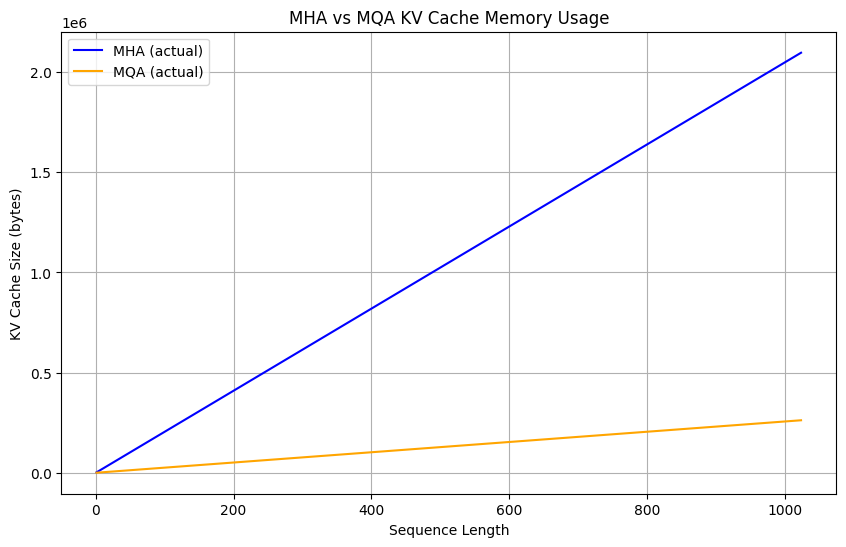

In [5]:
# Theoretical
theo_mha_per_token = num_layers * b * num_heads * head_dim * 2 * 4
theo_mqa_per_token = num_layers * b * 1 * head_dim * 2 * 4
print(f"\nTheoretical bytes per additional token - MHA: {theo_mha_per_token}, MQA: {theo_mqa_per_token}")
print("Note: Actual sizes match theoretical KV cache (excluding other memory).")

if torch.cuda.is_available():
    peak_gpu = torch.cuda.max_memory_allocated()
    print(f"Peak GPU memory (both models): {peak_gpu} bytes (~{peak_gpu / 1024 / 1024:.2f} MB)")

# Plot KV cache vs seq_len
s_list = np.arange(1, max_s + 1)
plt.figure(figsize=(10, 6))
plt.plot(s_list, mha_sizes, label='MHA (actual)', color='blue')
plt.plot(s_list, mqa_sizes, label='MQA (actual)', color='orange')
plt.xlabel('Sequence Length')
plt.ylabel('KV Cache Size (bytes)')
plt.title('MHA vs MQA KV Cache Memory Usage')
plt.legend()
plt.grid(True)
# plt.yscale('log')  # Uncomment for log scale on long seqs
plt.savefig('mha_mqa_comparison.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved as 'mha_mqa_comparison.png'. MHA uses {num_heads}x more KV cache than MQA.")

Also, lets test in the real pretrained models that have MHA and MQA.

In [6]:
!pip install -qq transformers accelerate

In [35]:
#@ Starting with imports once again
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from contextlib import nullcontext

In [8]:
class KVCacheHook:
    """Hook to track KV cache sizes during forward pass."""
    def __init__(self):
        self.sizes = []

    def pre_forward(self, module, input, cache):
        # Placeholder for pre-hook if needed
        pass

    def post_forward(self, module, input, output, cache):
        if cache is not None:
            total_bytes = 0
            for layer_cache in cache:
                if isinstance(layer_cache, tuple) and len(layer_cache) == 2:
                    k, v = layer_cache
                    total_bytes += (k.numel() + v.numel()) * k.element_size()
                elif hasattr(layer_cache, 'key_cache') and hasattr(layer_cache, 'value_cache'):
                    # For some model formats (e.g., if using past_key_values)
                    total_bytes += (layer_cache.key_cache.numel() + layer_cache.value_cache.numel()) * layer_cache.key_cache.element_size()
            self.sizes.append(total_bytes)

In [43]:
def generate_with_cache(model, tokenizer, prompt, max_new_tokens, device, use_cache=True):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs.get("attention_mask")

    kv_sizes = []
    generated = input_ids

    with torch.no_grad():
        for _ in range(max_new_tokens):
            outputs = model(generated, attention_mask=attention_mask, use_cache=use_cache)
            logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=-1)
            if attention_mask is not None:
                attention_mask = torch.cat([attention_mask, torch.ones_like(next_token)], dim=-1)

            if use_cache and hasattr(outputs, 'past_key_values'):
                cache = outputs.past_key_values
                total_bytes = 0
                num_heads = model.config.num_attention_heads if hasattr(model.config, 'num_attention_heads') else 1
                num_kv_heads = getattr(model.config, 'num_kv_heads', num_heads)  # For MQA, this might be 1
                for layer_cache in cache:
                    if isinstance(layer_cache, tuple) and len(layer_cache) == 2:
                        k, v = layer_cache
                        # Adjust for actual heads used (MHA stores all, MQA stores 1)
                        head_factor = num_heads if num_kv_heads == num_heads else 1  # MHA uses all heads, MQA uses 1 KV
                        total_bytes += (k.numel() + v.numel()) * k.element_size() * (num_heads / num_kv_heads if num_kv_heads > 0 else 1)
                kv_sizes.append(total_bytes)

    return kv_sizes

In [44]:
# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_new_tokens = 256
prompt = "Hello, world! " * 20

print(f"Device: {device}")
print(f"Generating {max_new_tokens} tokens on {device}...")

Device: cuda
Generating 256 tokens on cuda...


In [45]:
# Load MHA model: GPT-Neo-1.3B (~1.3B params)
print("\nLoading MHA model (GPT-Neo-1.3B)...")
mha_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B", torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32, device_map="auto")
mha_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
if mha_tokenizer.pad_token is None:
    mha_tokenizer.pad_token = mha_tokenizer.eos_token

# Load MQA model: Falcon-RW-1B (~1B params)
print("Loading MQA model (Falcon-RW-1B)...")
mqa_model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-rw-1b", torch_dtype=torch.float16 if device.type == 'cuda' else torch.float32, device_map="auto", trust_remote_code=True)
mqa_tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-rw-1b")
if mqa_tokenizer.pad_token is None:
    mqa_tokenizer.pad_token = mqa_tokenizer.eos_token


Loading MHA model (GPT-Neo-1.3B)...
Loading MQA model (Falcon-RW-1B)...


In [46]:
# Model param memory
mha_params_bytes = sum(p.numel() * p.element_size() for p in mha_model.parameters())
mqa_params_bytes = sum(p.numel() * p.element_size() for p in mqa_model.parameters())
print(f"\nMHA (GPT-Neo-1.3B) params memory: {mha_params_bytes / 1024**2:.2f} MB")
print(f"MQA (Falcon-RW-1B) params memory: {mqa_params_bytes / 1024**2:.2f} MB")

# Generate and track KV cache
ctx = nullcontext() if device.type == 'cpu' else torch.cuda.amp.autocast()
with ctx:
    print("\nSimulating generation for MHA...")
    mha_sizes = generate_with_cache(mha_model, mha_tokenizer, prompt, max_new_tokens, device)
    print("Simulating generation for MQA...")
    mqa_sizes = generate_with_cache(mqa_model, mqa_tokenizer, prompt, max_new_tokens, device)

# Debug: Print raw sizes to verify
print(f"\nDebug - MHA sizes length: {len(mha_sizes)}, first few: {mha_sizes[:5]}")
print(f"Debug - MQA sizes length: {len(mqa_sizes)}, first few: {mqa_sizes[:5]}")


MHA (GPT-Neo-1.3B) params memory: 2509.26 MB
MQA (Falcon-RW-1B) params memory: 2501.73 MB

Simulating generation for MHA...


/tmp/ipython-input-3603192471.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = nullcontext() if device.type == 'cpu' else torch.cuda.amp.autocast()


Simulating generation for MQA...

Debug - MHA sizes length: 256, first few: [15925248.0, 16121856.0, 16318464.0, 16515072.0, 16711680.0]
Debug - MQA sizes length: 256, first few: [15925248.0, 16121856.0, 16318464.0, 16515072.0, 16711680.0]


In [47]:
# Prompt lengths
mha_prompt_len = len(mha_tokenizer(prompt)["input_ids"])
mqa_prompt_len = len(mqa_tokenizer(prompt)["input_ids"])
seq_lens_mha = np.arange(mha_prompt_len + 1, mha_prompt_len + 1 + len(mha_sizes))
seq_lens_mqa = np.arange(mqa_prompt_len + 1, mqa_prompt_len + 1 + len(mqa_sizes))

In [48]:
# Pad shorter list
min_len = min(len(mha_sizes), len(mqa_sizes))
mha_sizes = mha_sizes[:min_len]
mqa_sizes = mqa_sizes[:min_len]
seq_lens = seq_lens_mha[:min_len]

In [51]:
# Print table
print("\nseq_len | MHA KV bytes | MQA KV bytes")
print("--------|--------------|--------------")
for i in range(0, min_len, 50):
    if i < 10:
        for j in range(i, min(i + 10, min_len)):
            print(f"{seq_lens[j]:7d} | {mha_sizes[j]:12.0f} | {mqa_sizes[j]:11.0f}") # Use .0f to format as float with no decimal places
    else:
        print(f"{seq_lens[i]:7d} | {mha_sizes[i]:12.0f} | {mqa_sizes[i]:11.0f}") # Use .0f to format as float with no decimal places


seq_len | MHA KV bytes | MQA KV bytes
--------|--------------|--------------
     82 |     15925248 |    15925248
     83 |     16121856 |    16121856
     84 |     16318464 |    16318464
     85 |     16515072 |    16515072
     86 |     16711680 |    16711680
     87 |     16908288 |    16908288
     88 |     17104896 |    17104896
     89 |     17301504 |    17301504
     90 |     17498112 |    17498112
     91 |     17694720 |    17694720
    132 |     25755648 |    25755648
    182 |     35586048 |    35586048
    232 |     45416448 |    45416448
    282 |     55246848 |    55246848
    332 |     65077248 |    65077248


In [52]:
# Theoretical per-token
theo_mha_per_token = 24 * 1 * 16 * 128 * 2 * 2  # 24 layers, 16 heads, 128 dim, KV, f16
theo_mqa_per_token = 24 * 1 * 1 * 128 * 2 * 2    # 1 KV head
print(f"\nTheoretical bytes per additional token - MHA: {theo_mha_per_token} (~{theo_mha_per_token/1024:.1f} KB), MQA: {theo_mqa_per_token} (~{theo_mqa_per_token/1024:.1f} KB)")


Theoretical bytes per additional token - MHA: 196608 (~192.0 KB), MQA: 12288 (~12.0 KB)


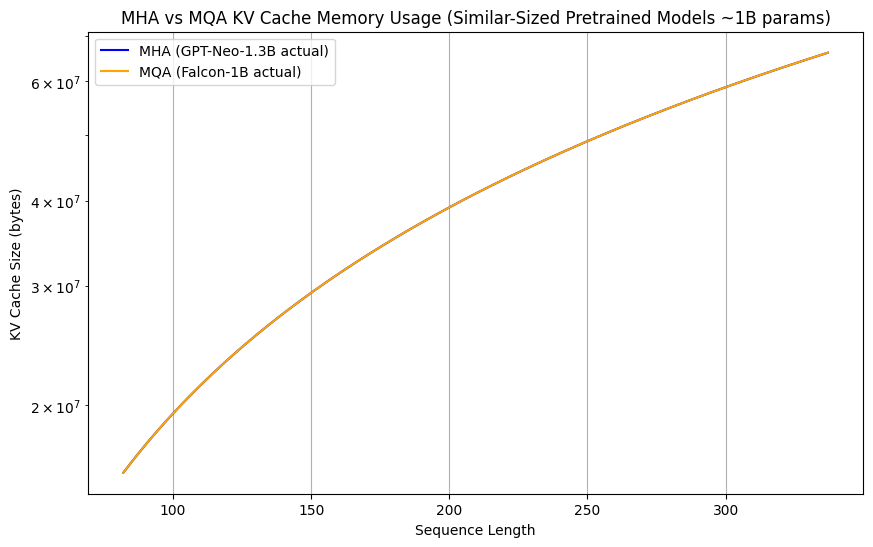

In [53]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(seq_lens, mha_sizes, label='MHA (GPT-Neo-1.3B actual)', color='blue')
plt.plot(seq_lens, mqa_sizes, label='MQA (Falcon-1B actual)', color='orange')
plt.xlabel('Sequence Length')
plt.ylabel('KV Cache Size (bytes)')
plt.title('MHA vs MQA KV Cache Memory Usage (Similar-Sized Pretrained Models ~1B params)')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Log scale for better visibility
plt.savefig('mha_mqa_similar_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()